In [2]:
%config InlineBackend.figure_format = 'retina'


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.random as random
import jax.numpy as jnp
from jax import jit, grad, vmap
from jax.example_libraries import optimizers

import neural_tangents as nt
from neural_tangents import stax

from kernel_generalization import kernel_simulation as ker_sim
from kernel_generalization import kernel_spectrum as ker_spec
from kernel_generalization.utils import gegenbauer

from matplotlib.cm import get_cmap
plt.rcParams.update({'font.size': 14})
name = "tab20"
cmap = get_cmap(name) 
colors = cmap.colors 
savedir = "/n/holyscratch01/pehlevan_lab/Lab/aatanasov/"
figdir = "figures/"


2022-11-07 14:23:13.248949: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-07 14:23:22.781074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/helmod/apps/centos7/Core/cudnn/8.5.0.96_cuda11-fasrc01/lib/:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/extras/CUPTI/lib64/:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/lib64/:/n/helmod/apps/centos7/Core/cudnn/8.2.2.26_cuda11.4-fasrc01/lib64:/n/helmod/apps/centos7/Core/cuda/11.4.2-fasrc01/cuda/extras/CUPTI/lib64:/n/helmod/apps/centos7/Core/cuda/11.4.2-fasrc01/cuda/lib64:/n/helmod/apps/centos7/Core/cuda/11.4.2-fasrc01/cuda/lib:/n/helmod/apps/centos7/Core/cudnn/8.2.2.26_cuda11.4-fasrc01/lib64:/n/helmod/apps/centos7/Core/cuda/11.4.

In [5]:
print(jax.devices())

[StreamExecutorGpuDevice(id=0, process_index=0), StreamExecutorGpuDevice(id=1, process_index=0), StreamExecutorGpuDevice(id=2, process_index=0), StreamExecutorGpuDevice(id=3, process_index=0)]


In [6]:
def generate_synth_data(p, dim, key):
  x0 = random.normal(key, shape=(p,dim))
  x = x0 / np.outer(np.linalg.norm(x0, axis=1), np.ones(dim))
  return jnp.array(x)

def pure_target_fn(X, beta, k):
  dim = len(beta)
  z = np.dot(X, beta)
  y = gegenbauer.gegenbauer(z, k+1, dim)[k,:]
  return jnp.array(y)[:, jnp.newaxis]

def generate_train_data(p, beta, k, key):
  emp_dim = 100
  dim = len(beta)
  key, emp_key = random.split(key)
  X = generate_synth_data(p, dim, key)
  y = pure_target_fn(X, beta, k)
  return X, y

def format_ps(pvals):
  result = np.zeros(len(pvals), dtype=int)
  for i, p in enumerate(pvals):
    if p < 10:
      result[i] = p + (p % 2)
    elif p < 300:
      result[i] = p + 10 - (p % 10)
    elif p < 3000:
      result[i] = p + 100 - (p % 100)
    else:
      result[i] = p + 1000 - p % 1000
  return result     

from functools import partial
from jax import jvp, grad, jit

def param_dist(params0, paramsf):
  diff = norm(list(params0), list(paramsf))  
  return jnp.sum(jnp.array(jax.tree_util.tree_leaves(diff)))

def param_diff(params0, paramsf):
  return jax.tree_map(lambda x, y: y-x, params0, paramsf)

def jacobian_vector(apply_fn, X, params0, deltaparams):
  f0 = lambda params: apply_fn(params, X)
  return jvp(f0, [params0], [deltaparams])[1]

def hessian_vector(apply_fn, X, params0, deltaparams):
  f0 = lambda params: apply_fn(params, X)
  df0 = lambda params: jvp(f0, [params], [deltaparams])[1]
  return jvp(df0, [params0], [deltaparams])[1]

import neural_tangents as nt
from neural_tangents import stax

# Generate fully connected NN architecture
def fully_connected(num_layers, width, sigma):
  layers = []
  for i in range(num_layers):
    layers += [stax.Dense(width, W_std = sigma, b_std = 0), stax.Relu()]
  layers += [stax.Dense(1, W_std=sigma, b_std=0)] 
  return stax.serial(*layers)

def make_jax(params):
  new_params = []
  for i, layer in enumerate(params):
    new_layer = []
    for wnbs in layer:
      new_wnbs = jnp.array(wnbs)
      new_layer += [new_wnbs]
    new_layer = tuple(new_layer)
    new_params += [new_layer]
  return new_params

In [7]:
L = 3
N = 1000
P = 20000
k = 3
num_repeats = 20
d_key = 0
i_key = 0

## Experiment Parameters
num_repeats_ker = num_repeats
num_repeats_nn = num_repeats
num_iter_nn = int(3e4)
min_loss_nn = 1e-6

## NN Hyperparameters
lr = 0.008   # Only being used with adam
layers = L - 1   # Hidden layers
depth = L

# For now we are actually not ensembling
ensemble_size_list = [3]

## Dimension, sample sizes, max eigenvalue mode to generate data
dim = 10
num_p = 15
num_n = 5
logpmin = .5
lognmin = 1.5
logpmax = np.log10(10000-1)
lognmax = np.log10(1000)
p_test = 2000
kmax = 200

num_repeats_eNTK = num_repeats_ker
ensemble_size = 1

nvals = np.array([N])
pvals = np.array([P])


# Random keys
data_key, init_key = random.PRNGKey(d_key), random.PRNGKey(i_key)
init_keys = random.split(init_key, max(num_repeats_nn, num_repeats_ker))
train_key = random.split(data_key, len(pvals))

# Crucially independent test key!! 
test_key = random.PRNGKey(0)
beta_key, const_key, test_key = random.split(test_key, 3)

# Data:
beta = generate_synth_data(1, dim, beta_key)[0,:]
y_const = np.sqrt(np.mean((generate_train_data(1000, beta, k, const_key)[1])**2))
Xs_train = []; ys_train = []
for i, p in enumerate(pvals):
  X_train, y_train = generate_train_data(p, beta, k, train_key[i])
  y_train = y_train/y_const
  Xs_train += [X_train]
  ys_train += [y_train]
X_test, y_test = generate_train_data(p_test, beta, k, test_key)
y_test = y_test/y_const
test_set = X_test, y_test

savedir = "/n/holyscratch01/pehlevan_lab/Lab/aatanasov/"


In [8]:
k = 4
## Dimension, sample sizes, max eigenvalue mode to generate data
dim = 10
num_p = 15
num_n = 5
logpmin = .5
lognmin = 1.5
logpmax = np.log10(10000-1)
lognmax = np.log10(1000)
p_test = 2000
kmax = 200

num_repeats_eNTK = num_repeats_ker
ensemble_size = 1

# This is the sweep that we are going to be doing:
pvals = np.logspace(logpmin, logpmax, num=num_p).astype('int')
nvals = np.logspace(lognmin, lognmax, num=num_n).astype('int')
pvals = format_ps(pvals)


# Crucially independent test key!! 
test_key = random.PRNGKey(0)
beta_key, const_key, test_key = random.split(test_key, 3)

# Data:
train_sets = []
for d_key in range(20):
  print(f"d = {d_key}", end="\r")
  data_key = random.PRNGKey(d_key)
  train_key = random.split(data_key, len(pvals))
  beta = generate_synth_data(1, dim, beta_key)[0,:]
  y_const = np.sqrt(np.mean((generate_train_data(1000, beta, k, const_key)[1])**2))
  Xs_train = []; ys_train = []
  for i, p in enumerate(pvals):
    X_train, y_train = generate_train_data(p, beta, k, train_key[i])
    y_train = y_train/y_const
    Xs_train += [X_train]
    ys_train += [y_train]
  train_sets += [(Xs_train, ys_train)]

X_test, y_test = generate_train_data(p_test, beta, k, test_key)
y_test = y_test/y_const
test_set = (X_test, y_test)


sigmas = [0.1, 0.5, 1.0, 10.0, 20]
widths = nvals
numK = 3
numS = len(sigmas)
numN = len(widths)

numP = len(pvals)
numE = 20
numD = 20
P_test = 2000

NTK_errs = np.zeros(shape=(numS, numP, numD)) 
eNTK0_errs = np.zeros(shape=(numS, numN, numP, numE, numD)) 
yhats_eNTK0 = np.zeros(shape=(numS, numN, numP, numE, numD, P_test, 1)) 
NN_errs = np.zeros(shape=(numS, numN, numP, numE, numD))
yhats_NN = np.zeros(shape=(numS, numN, numP, numE, numD, P_test, 1)) 
eNTK0_err_rat = np.zeros(shape=(numS, numN, numP, numE, numD))
NN_err_rat = np.zeros(shape=(numS, numN, numP, numE, numD))


for d in range(20):
  print(f"d = {d}")
  for i, sigma in enumerate(sigmas):
    try: NTK_errs[i, :, d] = np.load(savedir+"inf_err_L={}_k={}_s={:.2f}_d={}.npy".format(depth, k, sigma, d))
    except: print(f"NTK error at sigma={sigma} d={d}")
    for j, width in enumerate(widths):    
      try: 
        NN_errs[i, j, :, :, d] = np.load(savedir+"gen_err_NN_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))
        yhats_NN[i, j, :, :, d, :, :] = np.load(savedir+"yhats_NN_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))      
      except: print(f"NN error at width={width}, sigma={sigma} d={d}")
      try: 
        eNTK0_errs[i, j, :, :, d] = np.load(savedir+"gen_err_eNTK0_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))
        yhats_eNTK0[i, j, :, :, d, :, :] = np.load(savedir+"yhats_eNTK0_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))
      except: print(f"eNTK0 error at width={width}, sigma={sigma} d={d}")
    

d = 09
d = 1
d = 2
eNTK0 error at width=31, sigma=0.5 d=2
NN error at width=74, sigma=0.5 d=2
eNTK0 error at width=74, sigma=0.5 d=2
NN error at width=177, sigma=0.5 d=2
eNTK0 error at width=177, sigma=0.5 d=2
NN error at width=421, sigma=0.5 d=2
eNTK0 error at width=421, sigma=0.5 d=2
NN error at width=1000, sigma=0.5 d=2
eNTK0 error at width=1000, sigma=0.5 d=2
d = 3
d = 4
eNTK0 error at width=1000, sigma=10.0 d=4
d = 5
d = 6
eNTK0 error at width=1000, sigma=0.1 d=6
eNTK0 error at width=1000, sigma=0.5 d=6
d = 7
d = 8
eNTK0 error at width=1000, sigma=0.1 d=8
eNTK0 error at width=1000, sigma=1.0 d=8
eNTK0 error at width=31, sigma=10.0 d=8
NN error at width=74, sigma=10.0 d=8
eNTK0 error at width=74, sigma=10.0 d=8
NN error at width=177, sigma=10.0 d=8
eNTK0 error at width=177, sigma=10.0 d=8
NN error at width=421, sigma=10.0 d=8
eNTK0 error at width=421, sigma=10.0 d=8
NN error at width=1000, sigma=10.0 d=8
eNTK0 error at width=1000, sigma=10.0 d=8
d = 9
eNTK0 error at width=1000, sig

In [23]:
k = 4

sigmas = [0.1, 0.5, 1.0, 10.0, 20]
widths = nvals
numK = 3
numS = len(sigmas)
numN = len(widths)

numP = 1  
numE = 20
numD = 20
P_test = 2000

NTK_errs_20k = np.zeros(shape=(numS, numP, numD)) 
eNTK0_errs_20k = np.zeros(shape=(numS, numN, numP, numE, numD)) 
yhats_eNTK0_20k = np.zeros(shape=(numS, numN, numP, numE, numD, P_test, 1)) 
NN_errs_20k = np.zeros(shape=(numS, numN, numP, numE, numD))
yhats_NN_20k = np.zeros(shape=(numS, numN, numP, numE, numD, P_test, 1)) 
eNTK0_err_rat_20k = np.zeros(shape=(numS, numN, numP, numE, numD))
NN_err_rat_20k = np.zeros(shape=(numS, numN, numP, numE, numD))


for d in range(20):
  print(f"d = {d}")
  for i, sigma in enumerate(sigmas):
    try: NTK_errs_20k[i, :, d] = np.load(savedir+"inf_err_P={}_L={}_k={}_s={:.2f}_d={}.npy".format(P, depth, k, sigma, d))
    except: print(f"NTK error at sigma={sigma} d={d}")
    for j, width in enumerate(widths):    
      if j < len(widths)-1: continue
      try: 
        NN_errs_20k[i, j, :, :, d] = np.load(savedir+"gen_err_NN_P={}_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(P, width, depth, k, sigma, d))
        yhats_NN_20k[i, j, :, :, d, :, :] = np.load(savedir+"yhats_NN_P={}_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(P, width, depth, k, sigma, d))      
      except: print(f"NN error at width={width}, sigma={sigma} d={d}")
      try: 
        eNTK0_errs_20k[i, j, :, :, d] = np.load(savedir+"gen_err_eNTK0_P={}_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(P, width, depth, k, sigma, d))
        yhats_eNTK0_20k[i, j, :, :, d, :, :] = np.load(savedir+"yhats_eNTK0_P={}_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(P, width, depth, k, sigma, d))
      except: print(f"eNTK0 error at width={width}, sigma={sigma} d={d}")
    

d = 0
d = 1
d = 2
d = 3
d = 4
d = 5
eNTK0 error at width=1000, sigma=0.1 d=5
d = 6
d = 7
d = 8
d = 9
d = 10
d = 11
d = 12
d = 13
d = 14
d = 15
d = 16
d = 17
d = 18
d = 19


In [45]:
%load_ext autoreload

In [13]:
import seaborn as sns
sns.set(font_scale=1.8)
sns.set_style("darkgrid")
sns.set_palette("seismic")

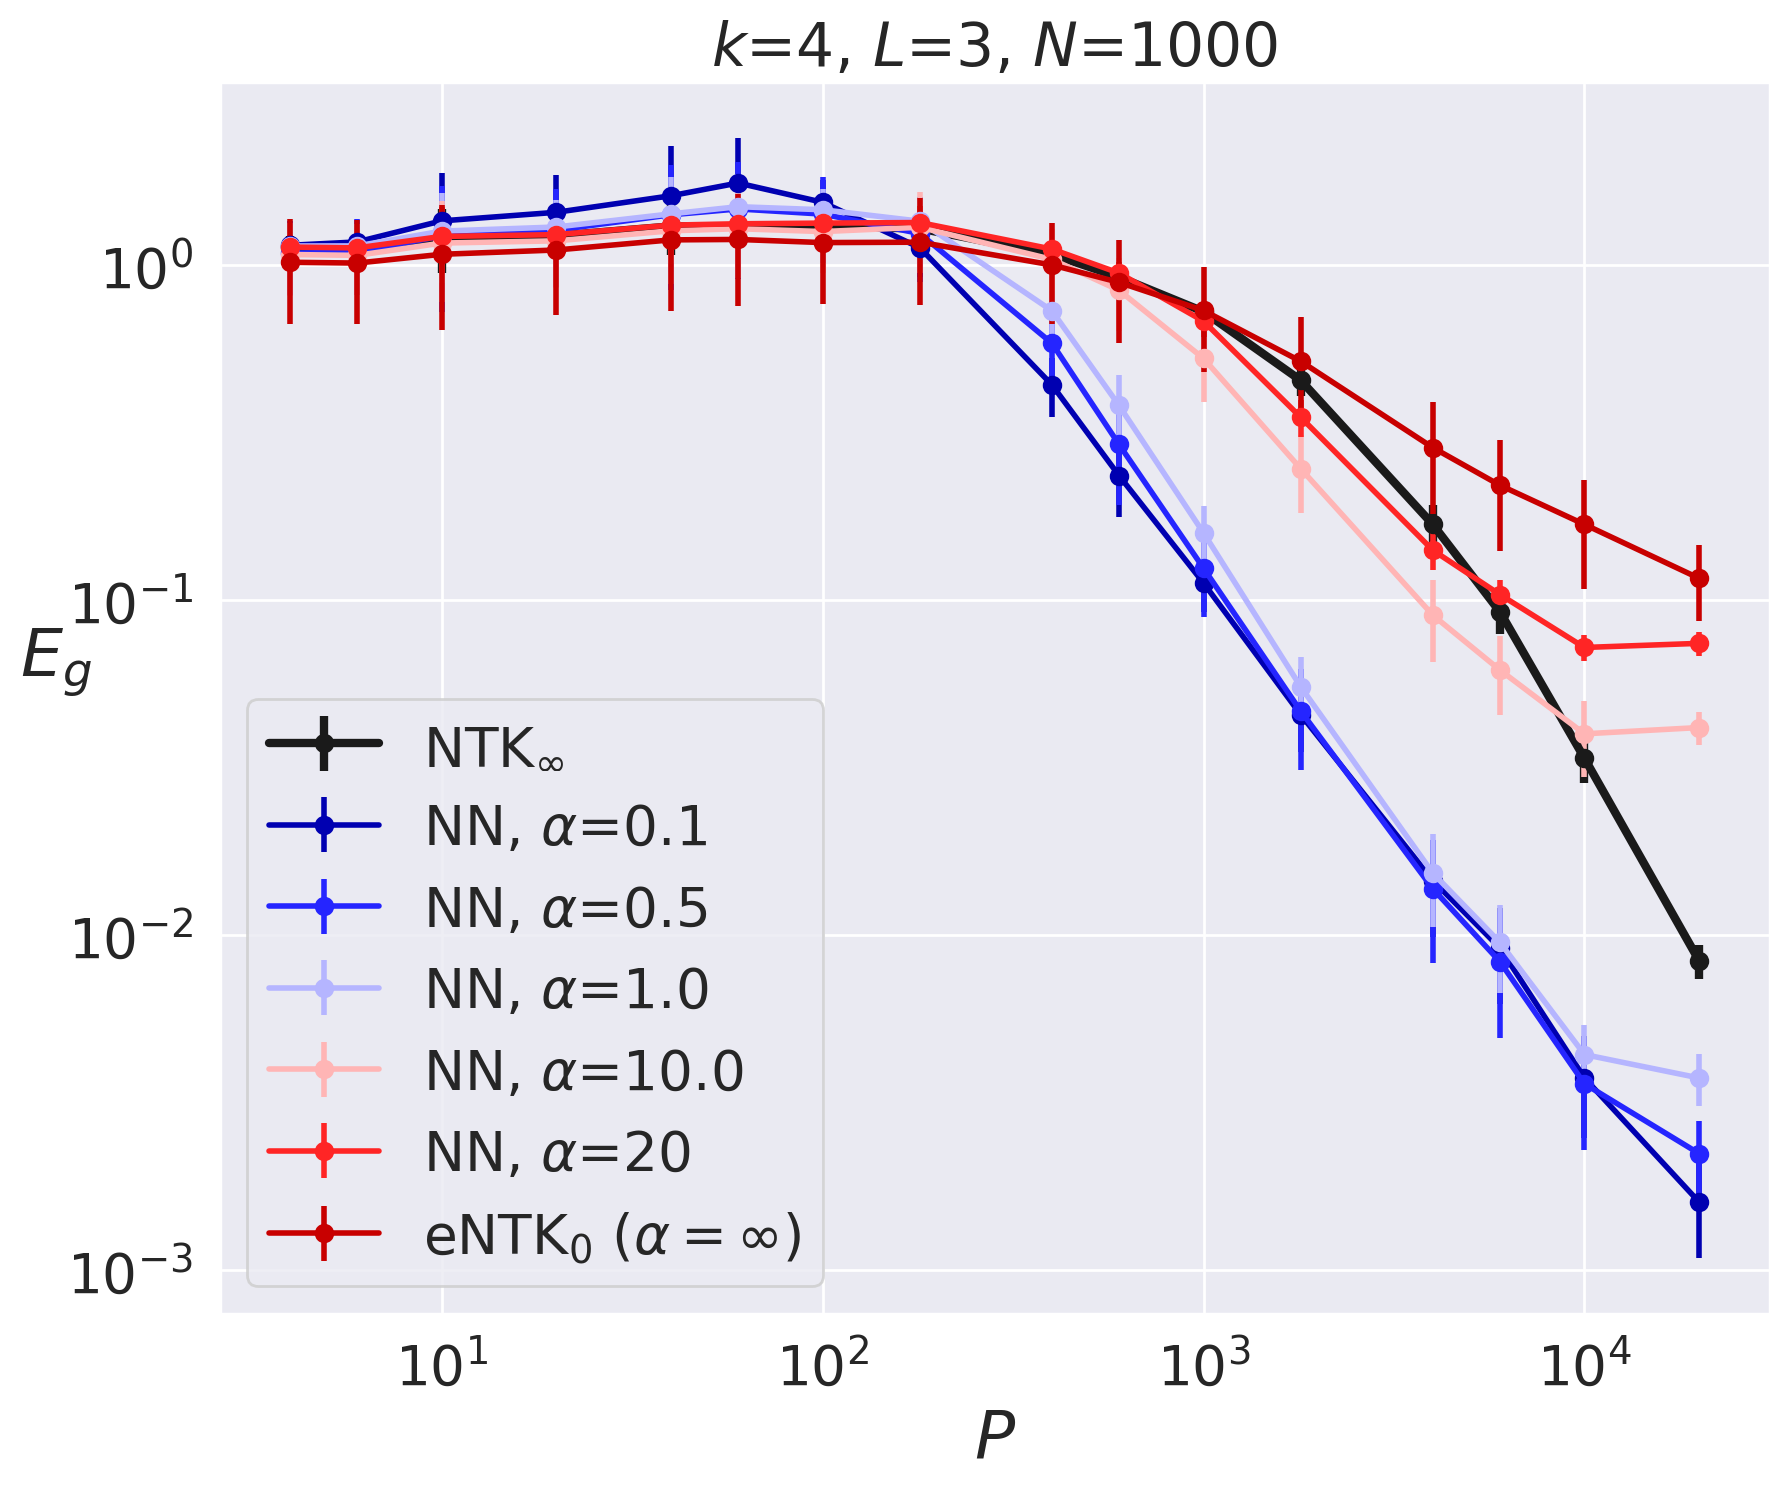

In [44]:
nidx=-1

fig = plt.figure(figsize=(10, 8))
ax = plt.axes()

NN_errs_final = np.concatenate((NN_errs, NN_errs_20k), axis=2)
yhats_NN_final = np.concatenate((yhats_NN, yhats_NN_20k), axis=2)
yhats_eNTK0_final = np.concatenate((yhats_eNTK0, yhats_eNTK0_20k), axis=2)
NTK_errs_final = np.concatenate((NTK_errs, NTK_errs_20k), axis=1)
eNTK0_errs_final = np.concatenate((eNTK0_errs, eNTK0_errs_20k), axis=2)
pvals_final = np.concatenate((pvals, [20000]))

ax.errorbar(pvals_final, np.nanmean(NTK_errs_final[-1, :, :], axis=-1), np.nanstd(NTK_errs_final[-1, :, :], axis=-1), c='k', fmt='o-', linewidth=3, label=f"NTK$_\infty$")

for i, sigma in enumerate(sigmas):
  ax.errorbar(pvals_final, np.nanmean(NN_errs_final[i, nidx, :, :, :], axis=(-2, -1)), np.nanstd(NN_errs_final[i, nidx, :, :, :], axis=(-2, -1)), fmt='o-', linewidth=2, label=f"NN, $\\alpha$={sigma}")

ax.errorbar(pvals_final, np.nanmean(eNTK0_errs_final[0, nidx, :, :, :], axis=(-2, -1)), np.nanstd(eNTK0_errs_final[0, nidx, :, :, :], axis=(-2, -1)), fmt='o-', linewidth=2, label=f"eNTK$_0$ ($\\alpha=\infty$)")



ax.set_xscale("log")
ax.set_yscale("log")

N = widths[nidx]

plt.title(f"$k$={k}, $L$={depth}, $N$={N}")
plt.xlabel("$P$", fontsize=24)
plt.ylabel("$E_g$", fontsize=24, rotation=0)
plt.legend()
plt.savefig(f"figures/ReLU_L={depth}_k={k}_N={N}_P={20000}.pdf")

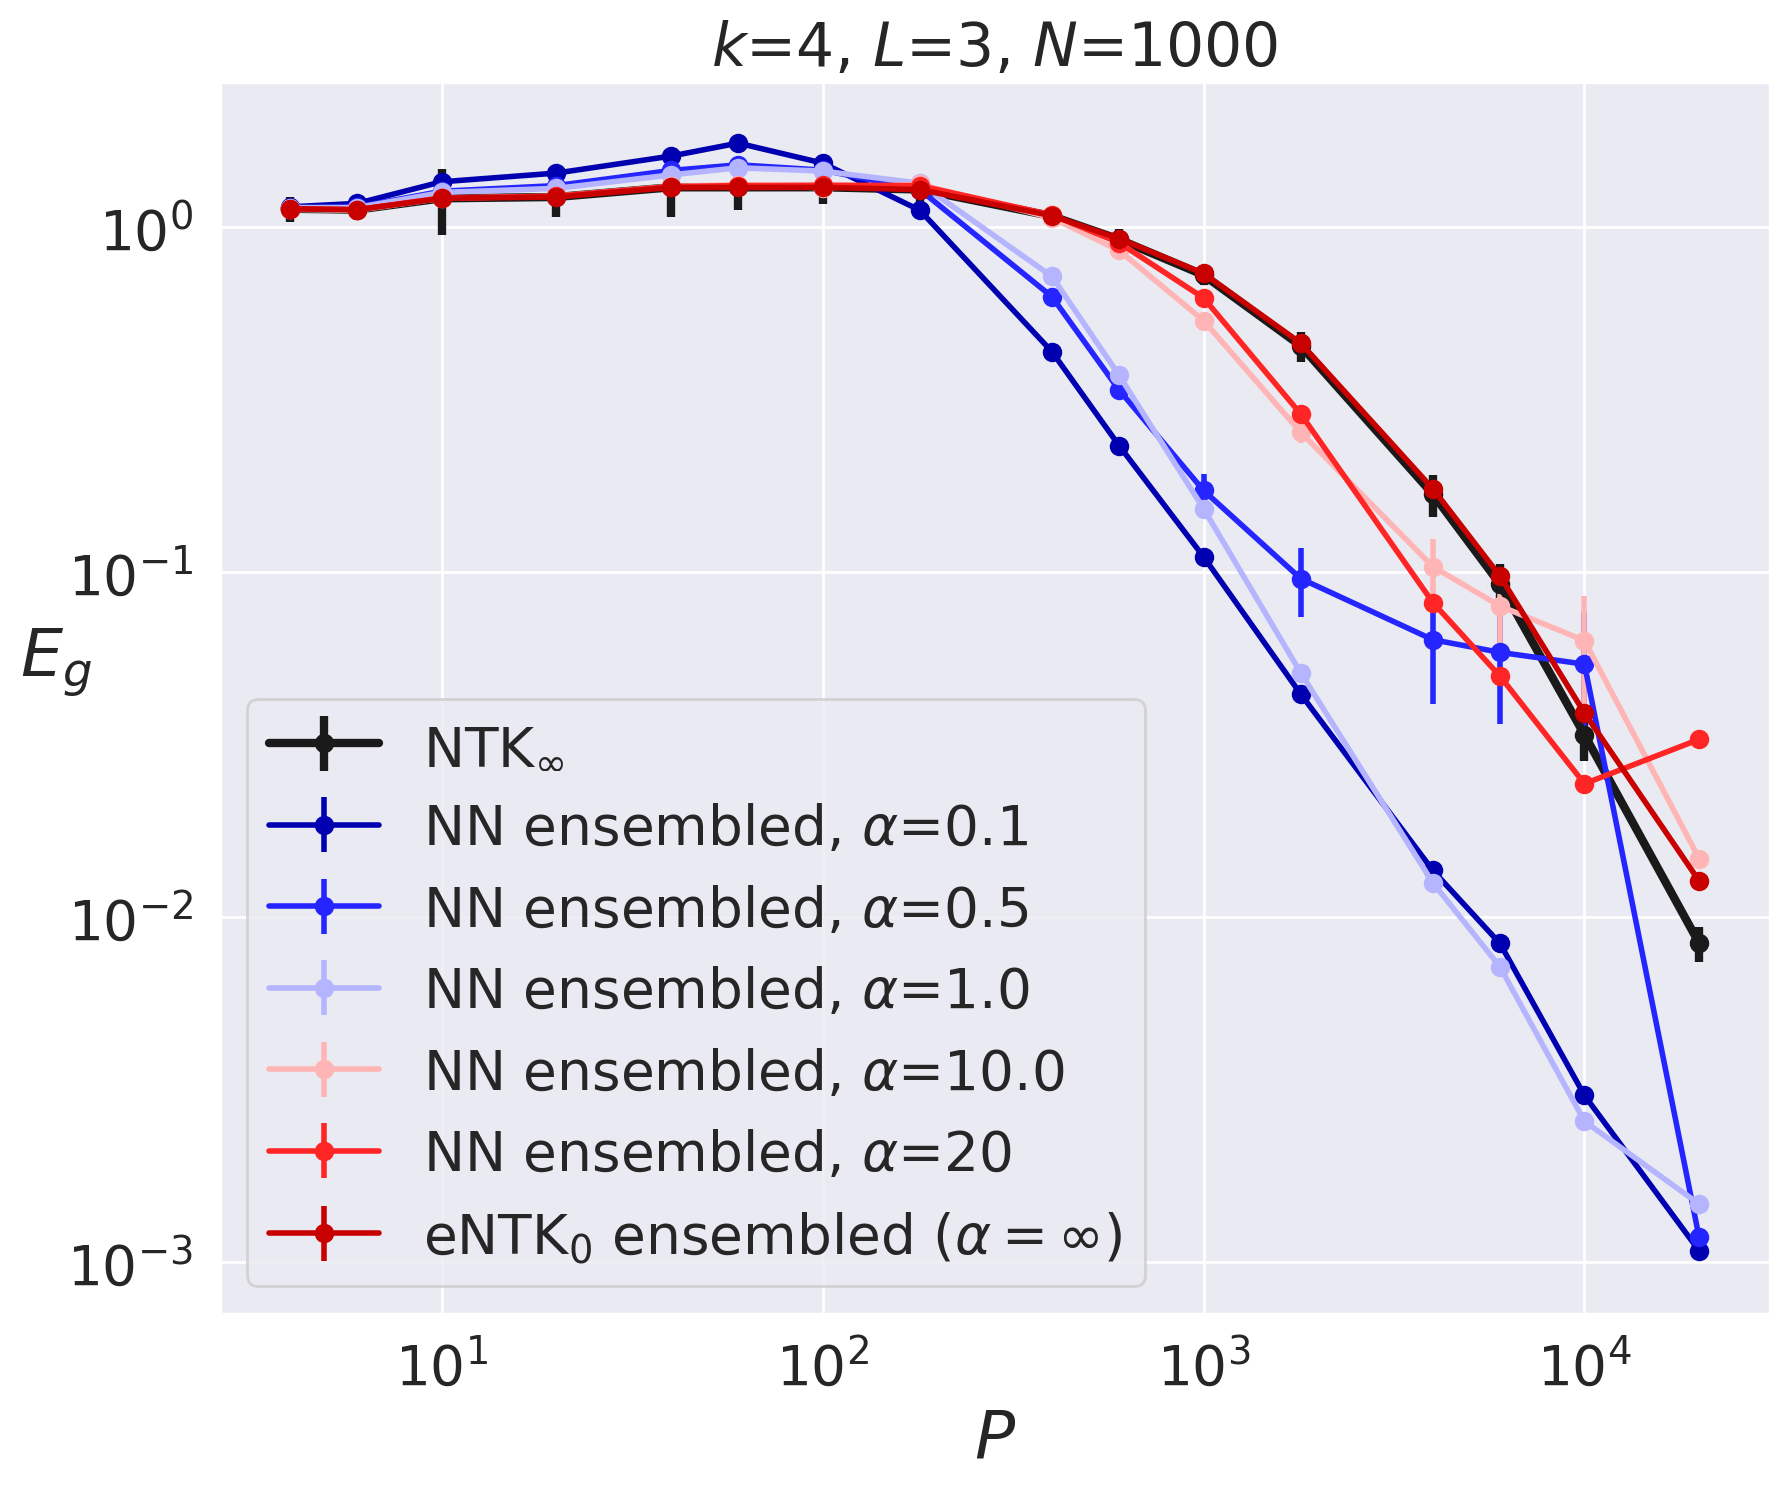

In [52]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()

ax.errorbar(pvals_final, np.nanmean(NTK_errs_final[-1, :, :], axis=-1), np.nanstd(NTK_errs_final[-1, :, :], axis=-1), c='k', fmt='o-', linewidth=3, label=f"NTK$_\infty$")

for i, sigma in enumerate(sigmas):
  NN_errs_ens = np.nanmean((np.nanmean(yhats_NN_final[i, nidx, :, :, :, :, 0], axis=1) - y_test[:, 0])**2, axis=-1)
  ax.errorbar(pvals_final, np.nanmean(NN_errs_ens, axis=-1),  np.nanstd(NN_errs_ens, axis=-1)/10, linewidth=2,fmt='o-', label=f"NN ensembled, $\\alpha$={sigma}")

eNTK0_errs_ens = np.nanmean((np.nanmean(yhats_eNTK0_final[i, nidx, :, :, :, :, 0], axis=1) - y_test[:, 0])**2, axis=-1)
ax.errorbar(pvals_final, np.nanmean(eNTK0_errs_ens, axis=-1),  np.nanstd(eNTK0_errs_ens, axis=-1)/10, linewidth=2, fmt='o-', label=f"eNTK$_0$ ensembled ($\\alpha=\infty$)")
ax.set_xscale("log")
ax.set_yscale("log")

plt.title(f"$k$={k}, $L$={depth}, $N$={N}")
plt.xlabel("$P$", fontsize=24)
plt.ylabel("$E_g$", fontsize=24, rotation=0)
plt.legend()
plt.savefig(f"figures/ReLU_ens_L={depth}_k={k}_N={N}_P={20000}.pdf")

In [44]:
!date -r  /n/holyscratch01/pehlevan_lab/Lab/aatanasov/gen_err_NN_N=1000_L=3_k=3_s=1.00_d=0.npy

Fri Sep 23 05:36:28 EDT 2022


In [43]:
!ls /n/holyscratch01/pehlevan_lab/Lab/aatanasov/gen_err_NN_N=1000_L=3_k=3_s=*_d=0.npy

/n/holyscratch01/pehlevan_lab/Lab/aatanasov/gen_err_NN_N=1000_L=3_k=3_s=0.10_d=0.npy
/n/holyscratch01/pehlevan_lab/Lab/aatanasov/gen_err_NN_N=1000_L=3_k=3_s=0.20_d=0.npy
/n/holyscratch01/pehlevan_lab/Lab/aatanasov/gen_err_NN_N=1000_L=3_k=3_s=0.50_d=0.npy
/n/holyscratch01/pehlevan_lab/Lab/aatanasov/gen_err_NN_N=1000_L=3_k=3_s=10.00_d=0.npy
/n/holyscratch01/pehlevan_lab/Lab/aatanasov/gen_err_NN_N=1000_L=3_k=3_s=1.00_d=0.npy
/n/holyscratch01/pehlevan_lab/Lab/aatanasov/gen_err_NN_N=1000_L=3_k=3_s=20.00_d=0.npy


In [15]:
savedir+"gen_err_NN_P={}_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(P, width, depth, k, sigma, d)

'/n/holyscratch01/pehlevan_lab/Lab/aatanasov/gen_err_NN_P=20000_N=10000_L=3_k=3_s=20.00_d=19.npy'